In [1]:
import re
import numpy as np
import pandas as pd

In [2]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
#spacy for lemmatization
import spacy


In [4]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Remove deprecationWarning that I can't fix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

In [6]:
# NLTK for removing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tagum', 'city', 'davao','ordinance','ii', 'penalties','nd','within','every','otherwise','thereof','section', 'municipal', 'municipality', 'government', 'series', 'continue', 'reading'])

In [7]:
# Import CSV Ordinance Dataset
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


In [8]:
# List all ordinance titles
# Convert to list
data = list(df.OT) 
print(data[:1])

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


In [9]:
# Remove qoutes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]

# Remove words ending with ING like amending, regulating
# Implemtation to be improved / Seems to improve topics
data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]


pprint(data[:5])

['“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES '
 'ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.',
 '“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) '
 'ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE '
 'UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, '
 'REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE '
 'PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”.',
 '“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FOR INDIGENT TAGUMENYOS, ITS '
 'MANAGEMENT, PROCEDURES AND GUIDELINES AND FUNDS THEREFOR”.',
 'AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 AND SECTION 3 OF CITY ORDINANCE '
 'NO. 820, S-2017 “AN ORDINANCE INTO A LOAN AGREEMENT WITH THE DEVELOPMENT '
 'BANK OF THE PHILIPPINES, IN THE AMOUNT OF SIX HUNDRED EIGHTY MILLION PESOS '
 '(P 680,000,000.00) TO FUND THE ACQUISITION OF HEAVY EQUIPMENT,ACQUISITION OF '
 'SERVICE VEHICLES, ACQUISITION O

In [10]:
#preprocess using gensim simple_preprocess and tokenize into words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'the',
  'practice',
  'of',
  'traditional',
  'home',
  'birth',
  'delivery',
  'or',
  'deliveries',
  'attended',
  'by',
  'traditional',
  'birth',
  'attendant',
  'or',
  'mananabang']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

['an',
 'ordinance',
 'the',
 'practice',
 'of',
 'traditional',
 'home',
 'birth',
 'delivery',
 'or',
 'deliveries',
 'attended',
 'by',
 'traditional',
 'birth',
 'attendant',
 'or',
 'mananabang']


In [13]:

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2)]]


In [16]:
id2word[0]

'attendant'

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attendant', 1),
  ('attended', 1),
  ('birth', 2),
  ('deliveries', 1),
  ('delivery', 1),
  ('home', 1),
  ('mananabang', 1),
  ('practice', 1),
  ('traditional', 2)]]

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.037*"thousand" + 0.036*"tax" + 0.032*"known" + 0.025*"code" + 0.021*"purposes" + 0.020*"traffic" + 0.017*"certain" + 0.016*"funds" + 0.015*"provided" + 0.015*"article"'), (1, '0.045*"office" + 0.025*"street" + 0.024*"public" + 0.023*"barangay" + 0.022*"lot" + 0.020*"portion" + 0.020*"area" + 0.019*"road" + 0.017*"streets" + 0.014*"meters"'), (2, '0.047*"violations" + 0.034*"violation" + 0.017*"inside" + 0.016*"establishments" + 0.016*"roads" + 0.011*"persons" + 0.011*"commercial" + 0.011*"penalty" + 0.010*"avenue" + 0.010*"areas"'), (3, '0.028*"medical" + 0.022*"rules" + 0.020*"two" + 0.019*"monthly" + 0.017*"mayor" + 0.017*"regulations" + 0.015*"magugpo" + 0.014*"management" + 0.014*"vice" + 0.013*"barangay"'), (4, '0.045*"funds" + 0.035*"position" + 0.033*"duties" + 0.024*"purpose" + 0.020*"legislative" + 0.020*"officer" + 0.019*"necessary" + 0.018*"department" + 0.016*"sangguniang" + 0.016*"salary"'), (5, '0.038*"market" + 0.030*"mayor" + 0.025*"public" + 0.018*"new" + 0.017

In [20]:
# Compute Perplexity
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.45497525411489637


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.296745  0.036264       1        1  19.878684
6     -0.045694 -0.189023       2        1  14.361796
5      0.126509 -0.013443       3        1  13.981903
4     -0.103326  0.174563       4        1  13.004676
0     -0.094663  0.128885       5        1  12.004517
2     -0.075386 -0.179374       6        1  10.785922
3     -0.042956  0.087408       7        1   8.669569
7     -0.061229 -0.045280       8        1   7.312934, topic_info=            Term       Freq      Total Category  logprob  loglift
215       office  68.000000  68.000000  Default  30.0000  30.0000
238   violations  39.000000  39.000000  Default  29.0000  29.0000
34         funds  67.000000  67.000000  Default  28.0000  28.0000
560       market  45.000000  45.000000  Default  27.0000  27.0000
464     thousand  34.000000  34.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
24   regulations  12.686420  26.354732   Topic8  -3.7785   1.8844
31     violation  13.657107  53.830116   Topic8  -3.7048   1.2440
16    guidelines   8.239164  35.627880   Topic8  -4.2102   1.1513
15     functions   4.338316  18.836526   Topic8  -4.8516   1.1472
77        school   4.019632  30.113029   Topic8  -4.9279   0.6018

[331 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
168       5  0.978588             act
541       4  0.841571      additional
184       7  0.866229      administer
9         8  0.964372  administrative
1372      4  0.929479   administrator
...     ...       ...             ...
154       8  0.976898         workers
119       2  0.299899            year
119       3  0.599799            year
733       4  0.909654           years
167       1  0.986633            zone

[342 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 5, 1, 3, 4, 8])

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=60, step=6)

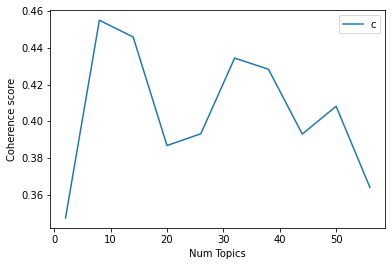

In [24]:
# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores with increasing number of topics

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    

Num Topics = 2  has Coherence Value of 0.3474
Num Topics = 8  has Coherence Value of 0.455
Num Topics = 14  has Coherence Value of 0.4459
Num Topics = 20  has Coherence Value of 0.3868
Num Topics = 26  has Coherence Value of 0.3932
Num Topics = 32  has Coherence Value of 0.4344
Num Topics = 38  has Coherence Value of 0.4283
Num Topics = 44  has Coherence Value of 0.393
Num Topics = 50  has Coherence Value of 0.4082
Num Topics = 56  has Coherence Value of 0.3641


In [26]:
# Select the model and print the topics
optimal_model = model_list[1] # when number of topics is 8
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.037*"thousand" + 0.036*"tax" + 0.032*"known" + 0.025*"code" + '
  '0.021*"purposes" + 0.020*"traffic" + 0.017*"certain" + 0.016*"funds" + '
  '0.015*"provided" + 0.015*"article"'),
 (1,
  '0.045*"office" + 0.025*"street" + 0.024*"public" + 0.023*"barangay" + '
  '0.022*"lot" + 0.020*"portion" + 0.020*"area" + 0.019*"road" + '
  '0.017*"streets" + 0.014*"meters"'),
 (2,
  '0.047*"violations" + 0.034*"violation" + 0.017*"inside" + '
  '0.016*"establishments" + 0.016*"roads" + 0.011*"persons" + '
  '0.011*"commercial" + 0.011*"penalty" + 0.010*"avenue" + 0.010*"areas"'),
 (3,
  '0.028*"medical" + 0.022*"rules" + 0.020*"two" + 0.019*"monthly" + '
  '0.017*"mayor" + 0.017*"regulations" + 0.015*"magugpo" + 0.014*"management" '
  '+ 0.014*"vice" + 0.013*"barangay"'),
 (4,
  '0.045*"funds" + 0.035*"position" + 0.033*"duties" + 0.024*"purpose" + '
  '0.020*"legislative" + 0.020*"officer" + 0.019*"necessary" + '
  '0.018*"department" + 0.016*"sangguniang" + 0.016*"salary"'),
 (5,
  '0.

In [33]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()




In [34]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 1000


sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9290,"thousand, tax, known, code, purposes, traffic, certain, funds, provided, article",AN ORDINANCE INCENTIVES TO ALL QUALIFIED BARANGAY NUTRITION SCHOLARS (BNS) IN THE CITY OF TAGUM AND FOR ITS POLICIES AND GUIDELINES AND FUNDS THEREOF OTHERWISE KNOWN AS “THE BARANGAY NUTRITION SCHOLARS CODE OF THE CITY OF TAGUM”.
1,1.0,0.9395,"office, street, public, barangay, lot, portion, area, road, streets, meters","“AN ORDINANCE THE PORTION OF THE CIRCUMFERENTIAL ROAD FROM THE JUNCTION OF DAVAO-AGUSAN NATIONAL HIGHWAY, CURVADA TO THE JUNCTION OF DALISAY-GANTE ROAD OF THIS MUNICIPALITY AS FELIX ALFELOR SR. STREET”."
2,2.0,0.9035,"violations, violation, inside, establishments, roads, persons, commercial, penalty, avenue, areas","“AN ORDINANCE THE OF FIREARMS AND OTHER DEADLY WEAPONS INSIDE RESTAURANTS, BEER HOUSES, NIGHT CLUBS, DISCO HOUSES, CABARETS, COCKPITS, ALLEYS, BILLIARD HALLS AND OTHER FUN HOUSES BEER AND LIQUOR AND PENALTIES FOR VIOLATION THEREOF”."
3,3.0,0.9404,"medical, rules, two, monthly, mayor, regulations, magugpo, management, vice, barangay",“AN ORDINANCE THE BARANGAY LOCAL GOVERNMENT UNIT (BLGU) TO STRENGTHEN THE IMPLEMENTATION OF THE SOLID WASTE MANAGEMENT LAWS AND ALL BARANGAYS TO SUBMIT THE MONTHLY WASTE DIVERSION REPORT EVERY TWO MONTHS”.
4,4.0,0.9486,"funds, position, duties, purpose, legislative, officer, necessary, department, sangguniang, salary","“AN ORDINANCE THE POSITIONS OF: (1) RECORDS OFFICER III; (1) LEGISLATIVE STAFF OFFICER II; (2) CLERK III & (1) BOOKBINDER II, ALL UNDER THE SECRETARIAT SERVICES OF THE SANGGUNIANG PANLUNGSOD, AND FOR THE QUALIFICATIONS, COMPENSATIONS, DUTIES AND RESPONSIBILITIES AND THE NECESSARY FUNDS FOR THE PURPOSE”."
5,5.0,0.9605,"market, mayor, public, new, fee, business, hon, school, residential, barangay","“AN ORDINANCE AND THE TERMS AND CONDITIONS CONTAINED IN THE TERM LOAN AGREEMENT AND DEED OF ASSIGNMENT WITH HOLD-OUT ENTERED INTO BY HON. ALLAN L. RELLON, DPA, PhD, CITY MAYOR/CHAIRPERSON LOCAL SCHOOL BOARD, IN BEHALF OF THE CITY GOVERNMENT OF TAGUM, DAVAO DEL NORTE, WITH THE DEVELOPMENT BANK OF THE PHILIPPINES THE continue reading : CITY ORDINANCE NO. 725, s-2015"
6,6.0,0.9491,"pesos, operation, vehicles, amount, use, hundred, five, service, public, augment","AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 AND SECTION 3 OF CITY ORDINANCE NO. 820, S-2017 “AN ORDINANCE INTO A LOAN AGREEMENT WITH THE DEVELOPMENT BANK OF THE PHILIPPINES, IN THE AMOUNT OF SIX HUNDRED EIGHTY MILLION PESOS (P 680,000,000.00) TO FUND THE ACQUISITION OF HEAVY EQUIPMENT,ACQUISITION OF SERVICE VEHICLES, ACQUISITION OF continue reading : CITY ORDINANCE NO. 844, s-2018"
7,7.0,0.9605,"fees, utility, tricycle, motorized, health, violation, revised, regulations, hire, workers","“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”."


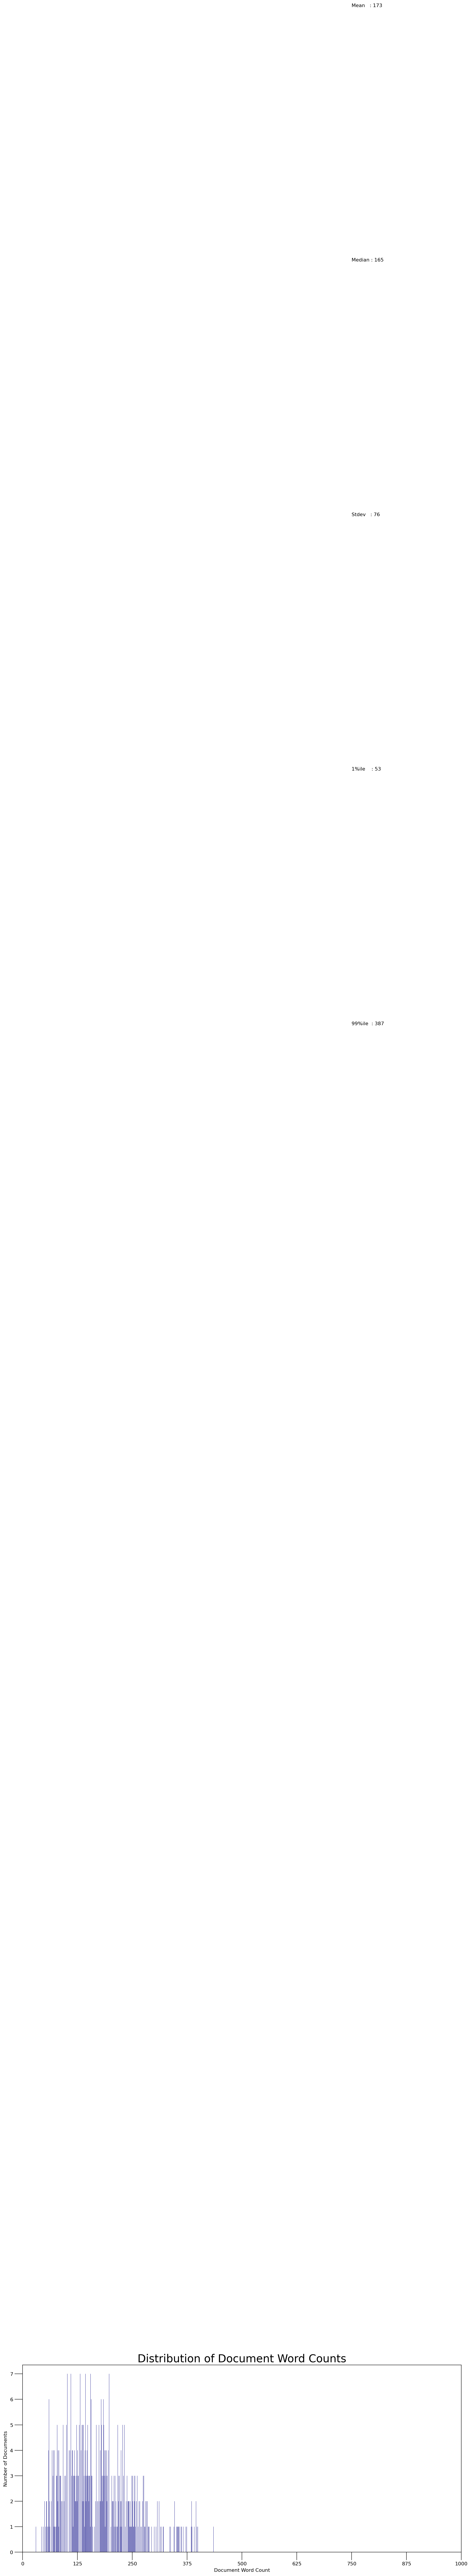

In [29]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

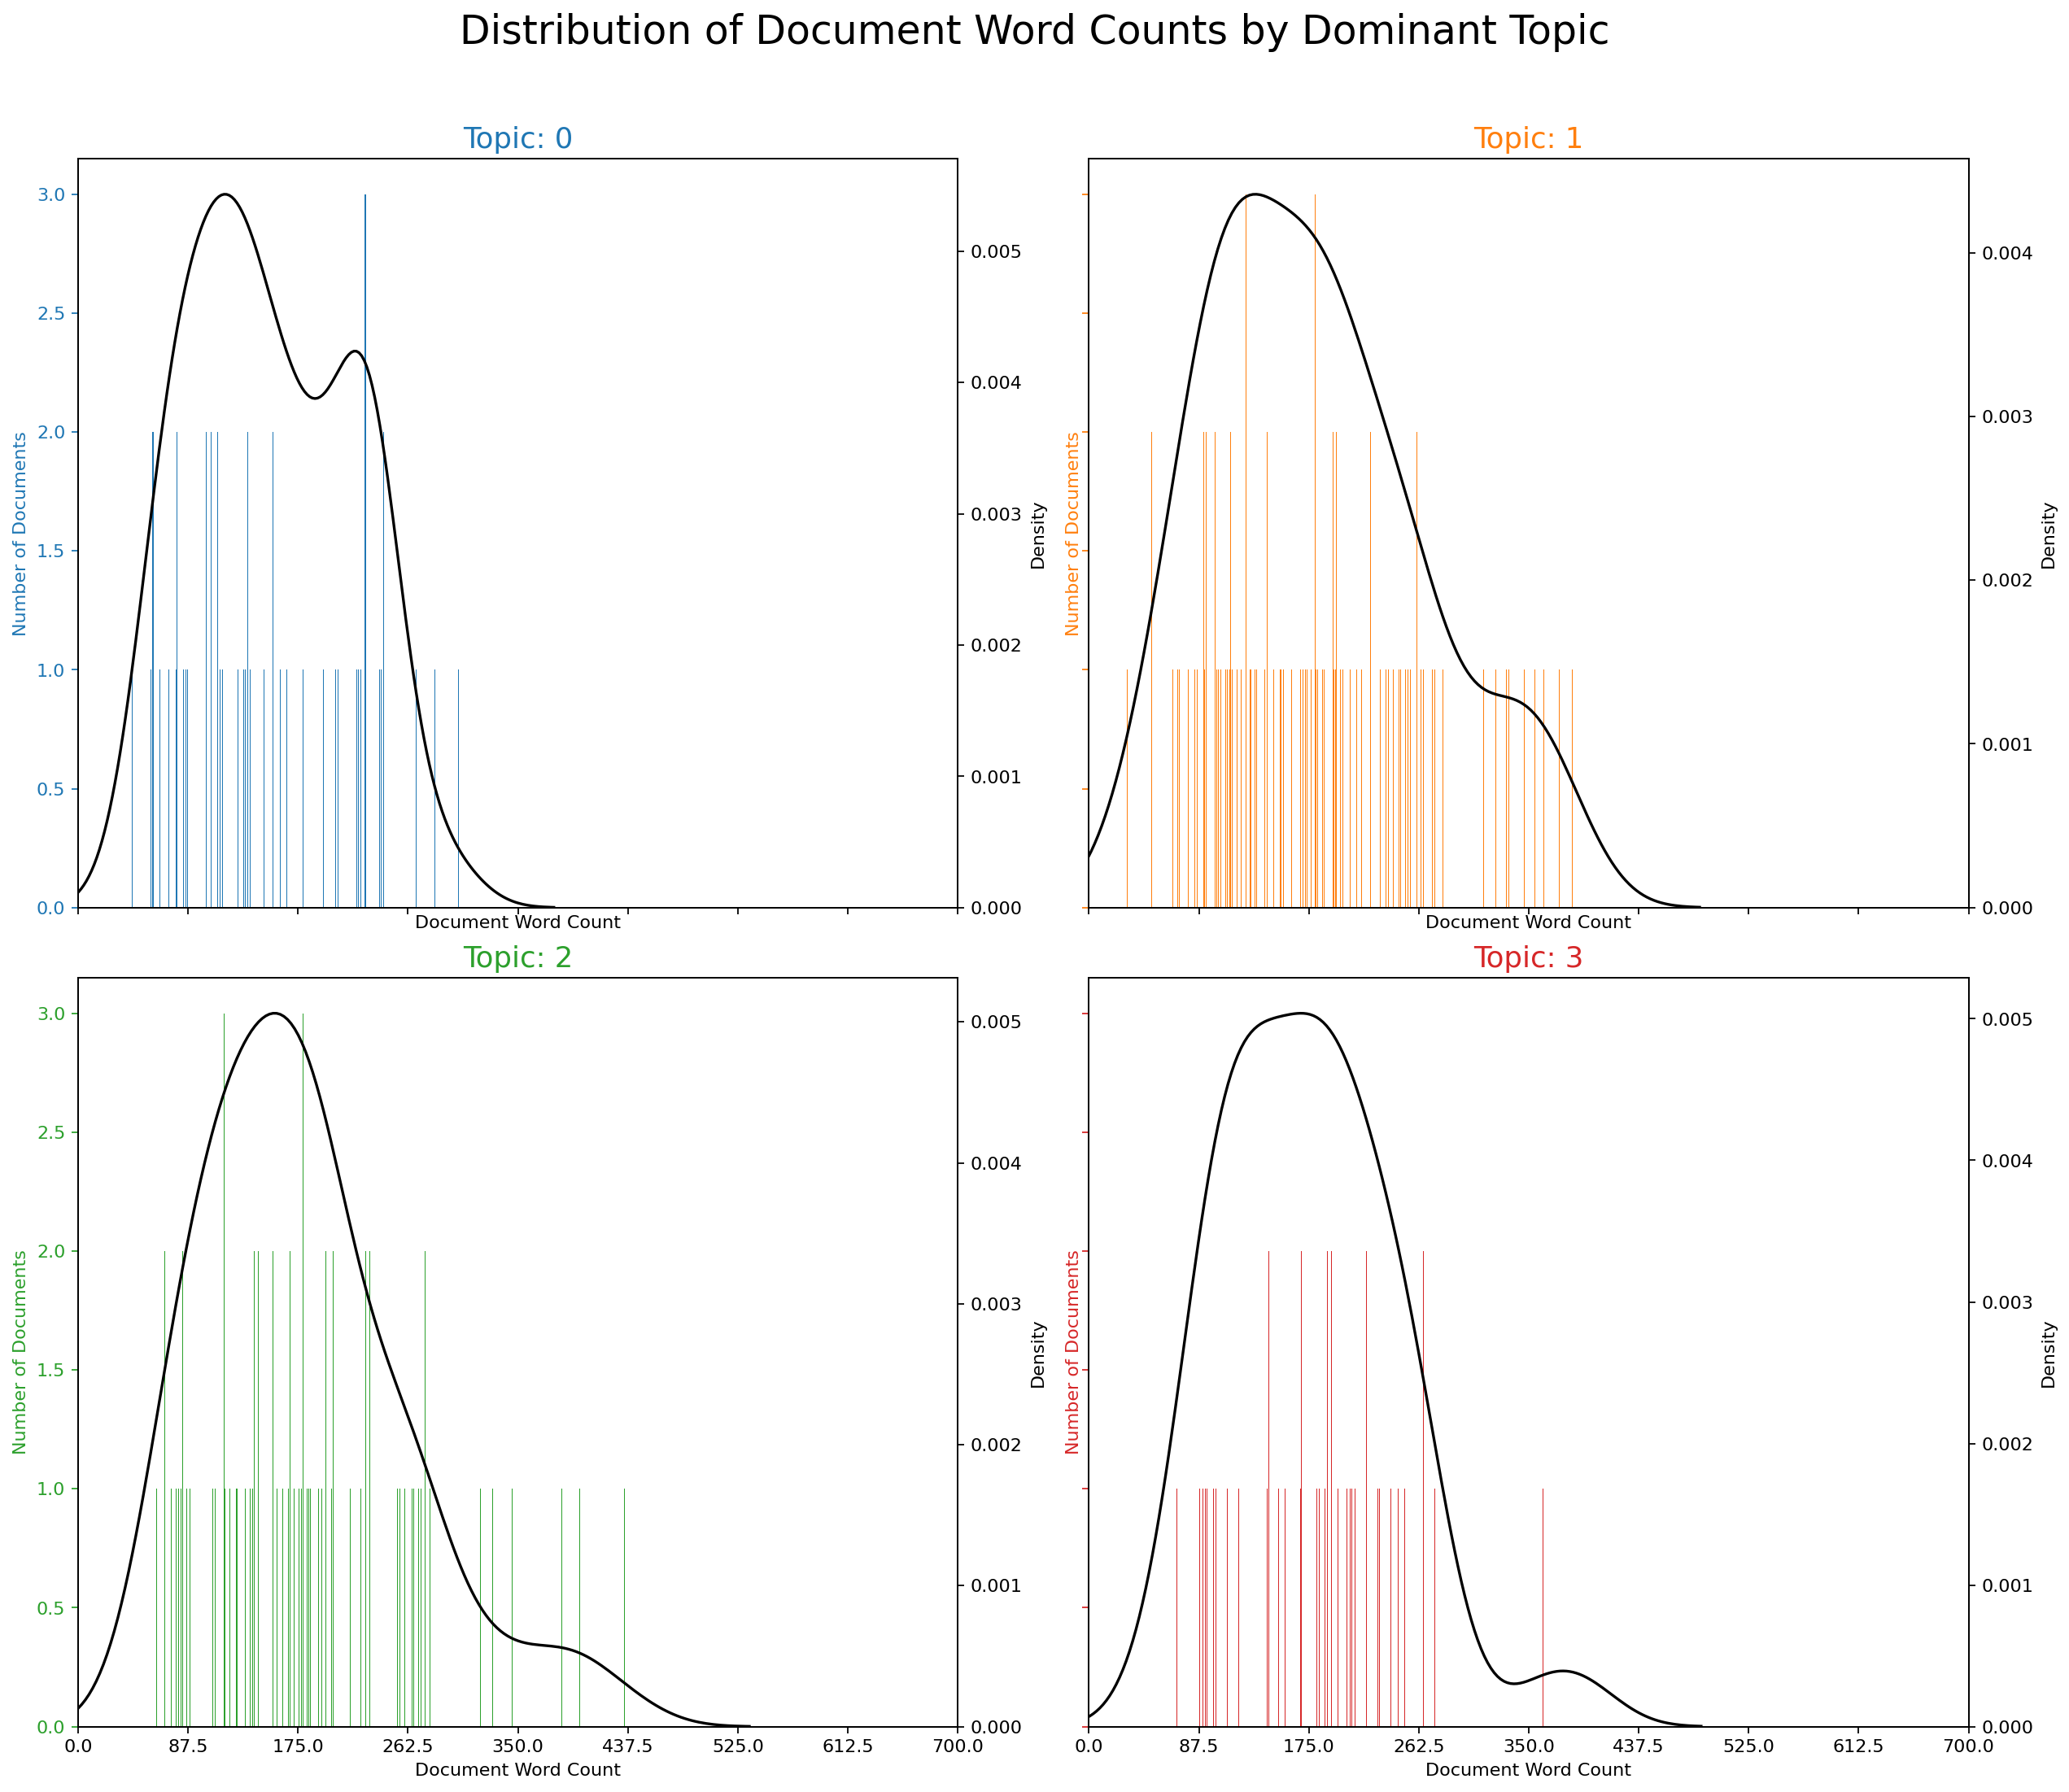

In [30]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 700, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 700), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,700,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

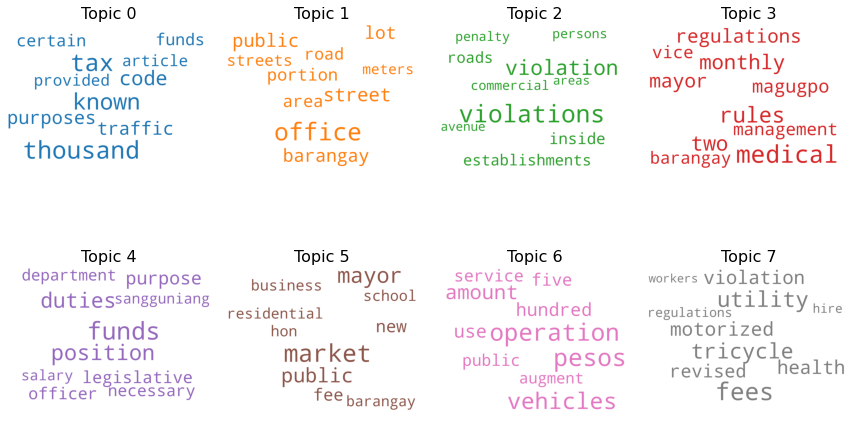

In [31]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(12,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

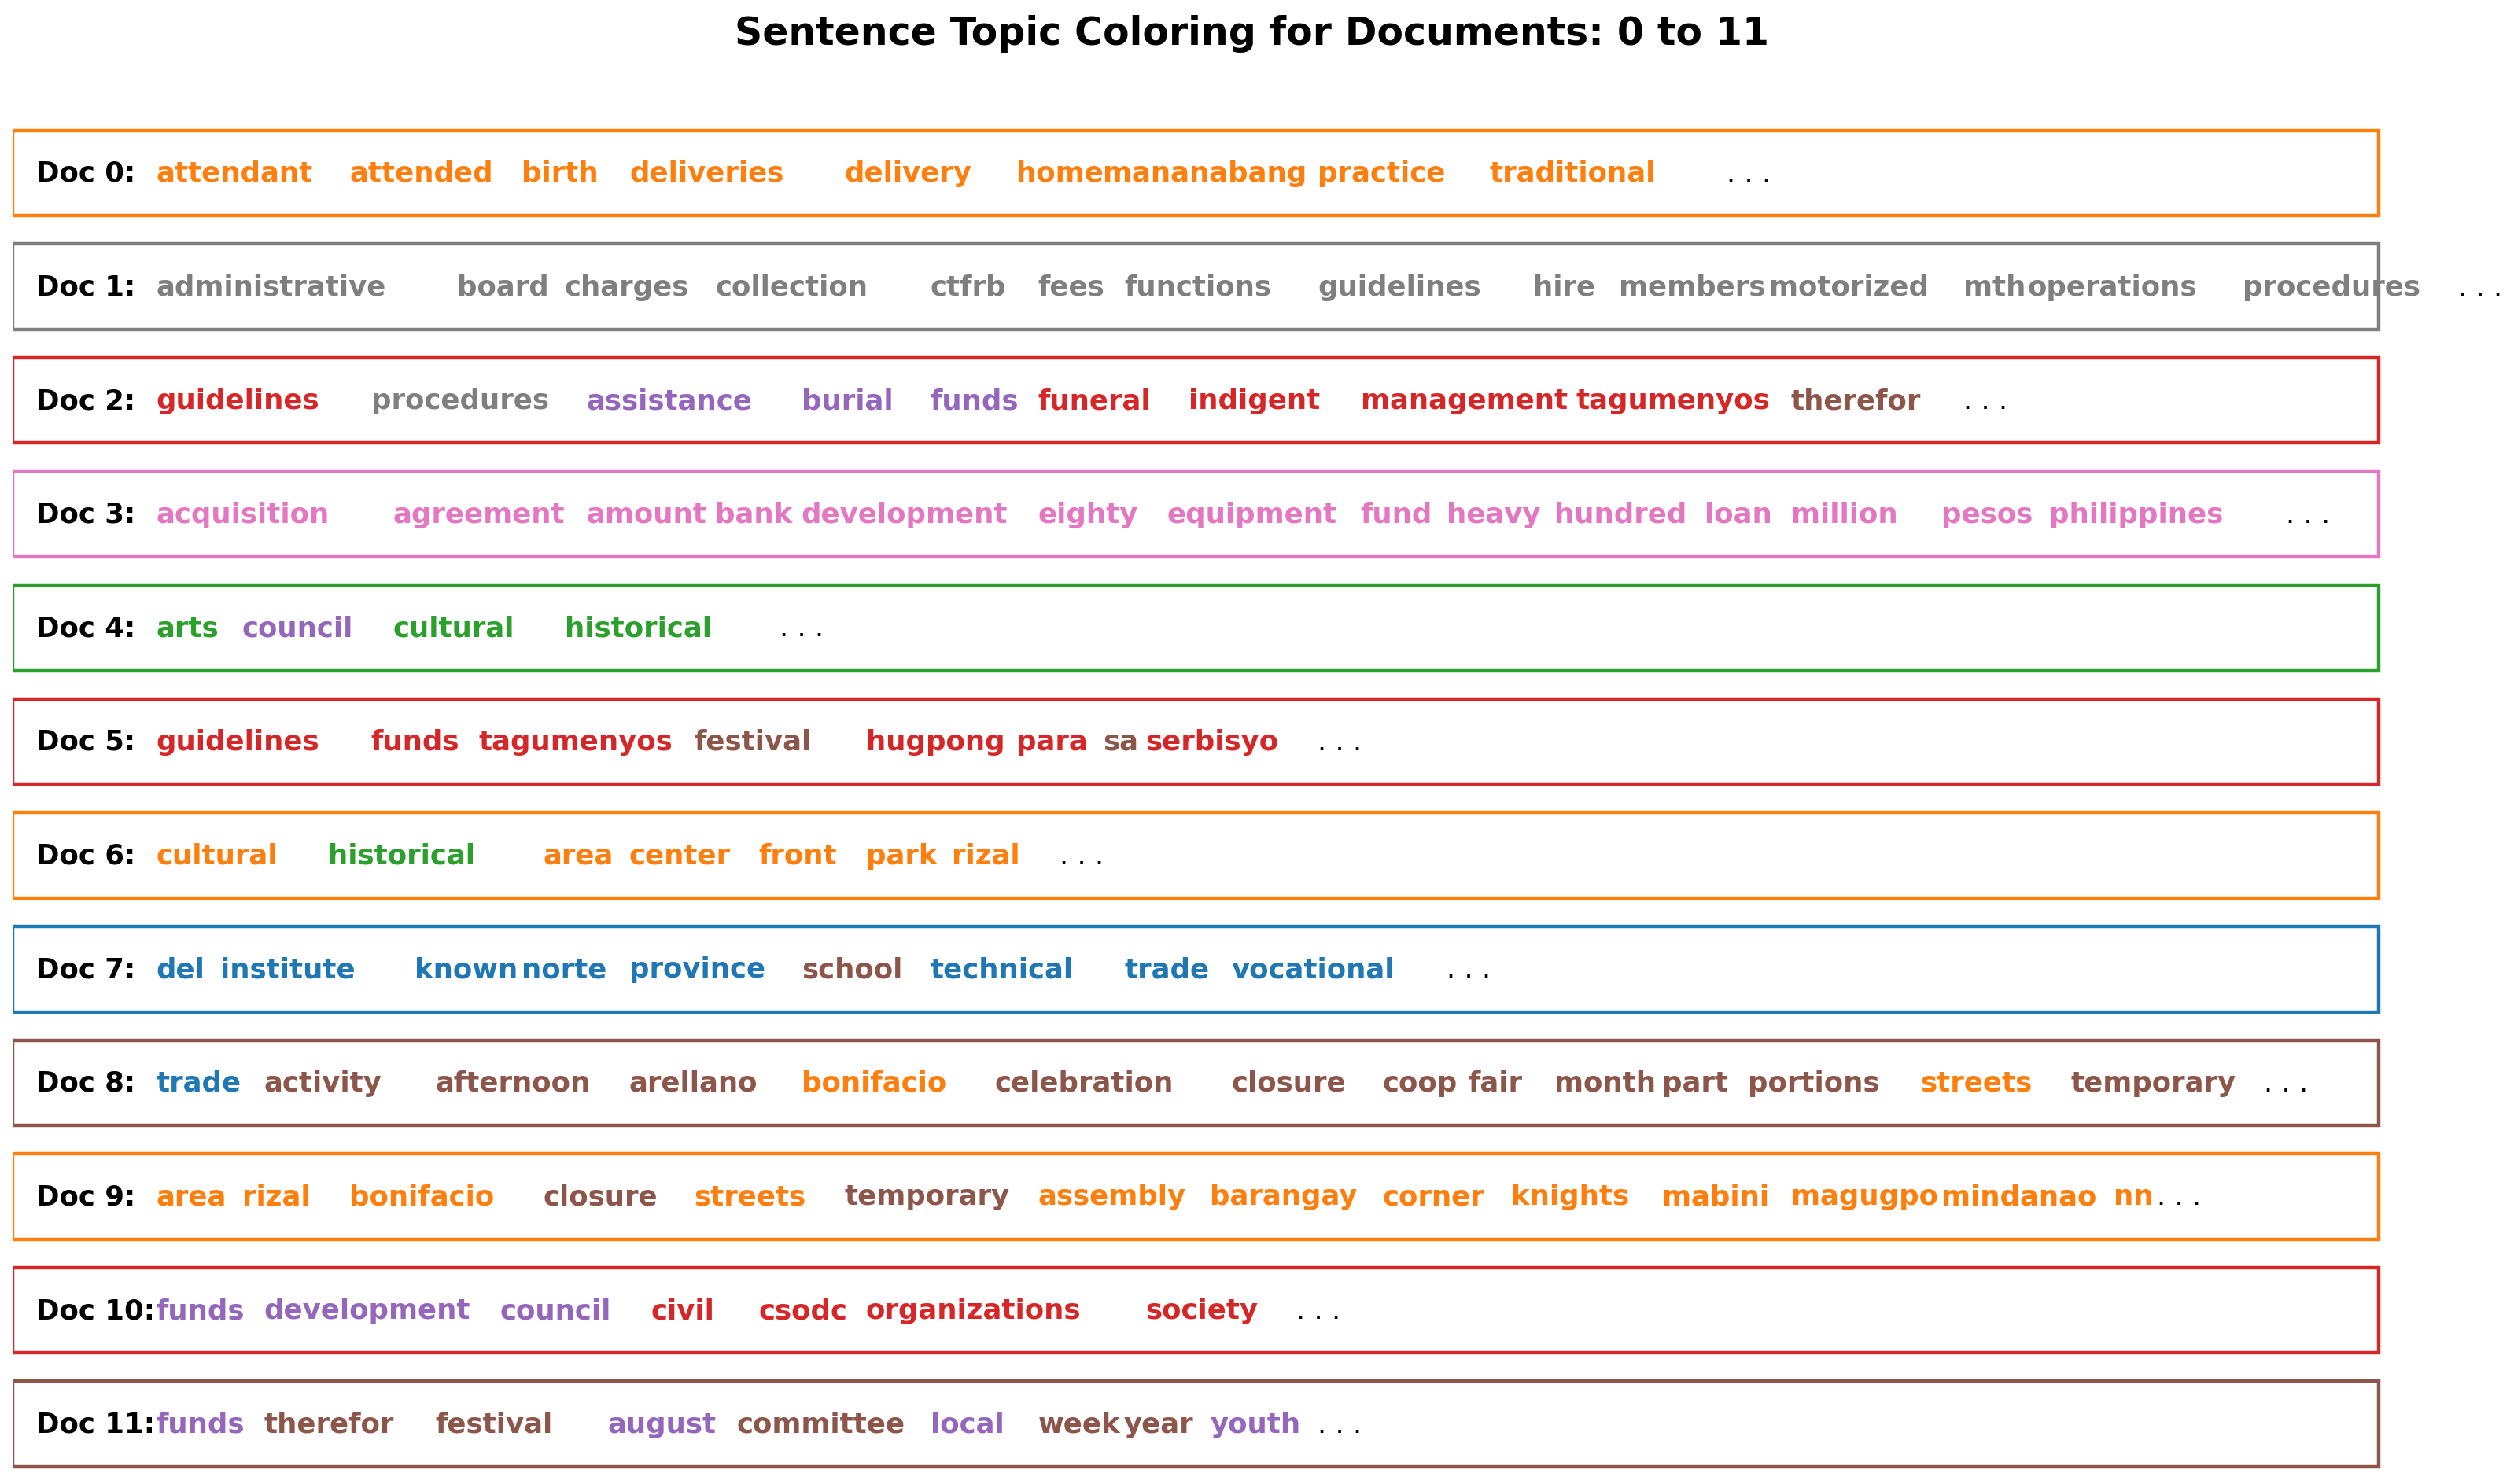

In [38]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

/var/folders/5w/v1hv7scs4gl14_30l_pjsrj00000gn/T/ipykernel_1658/4235454336.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


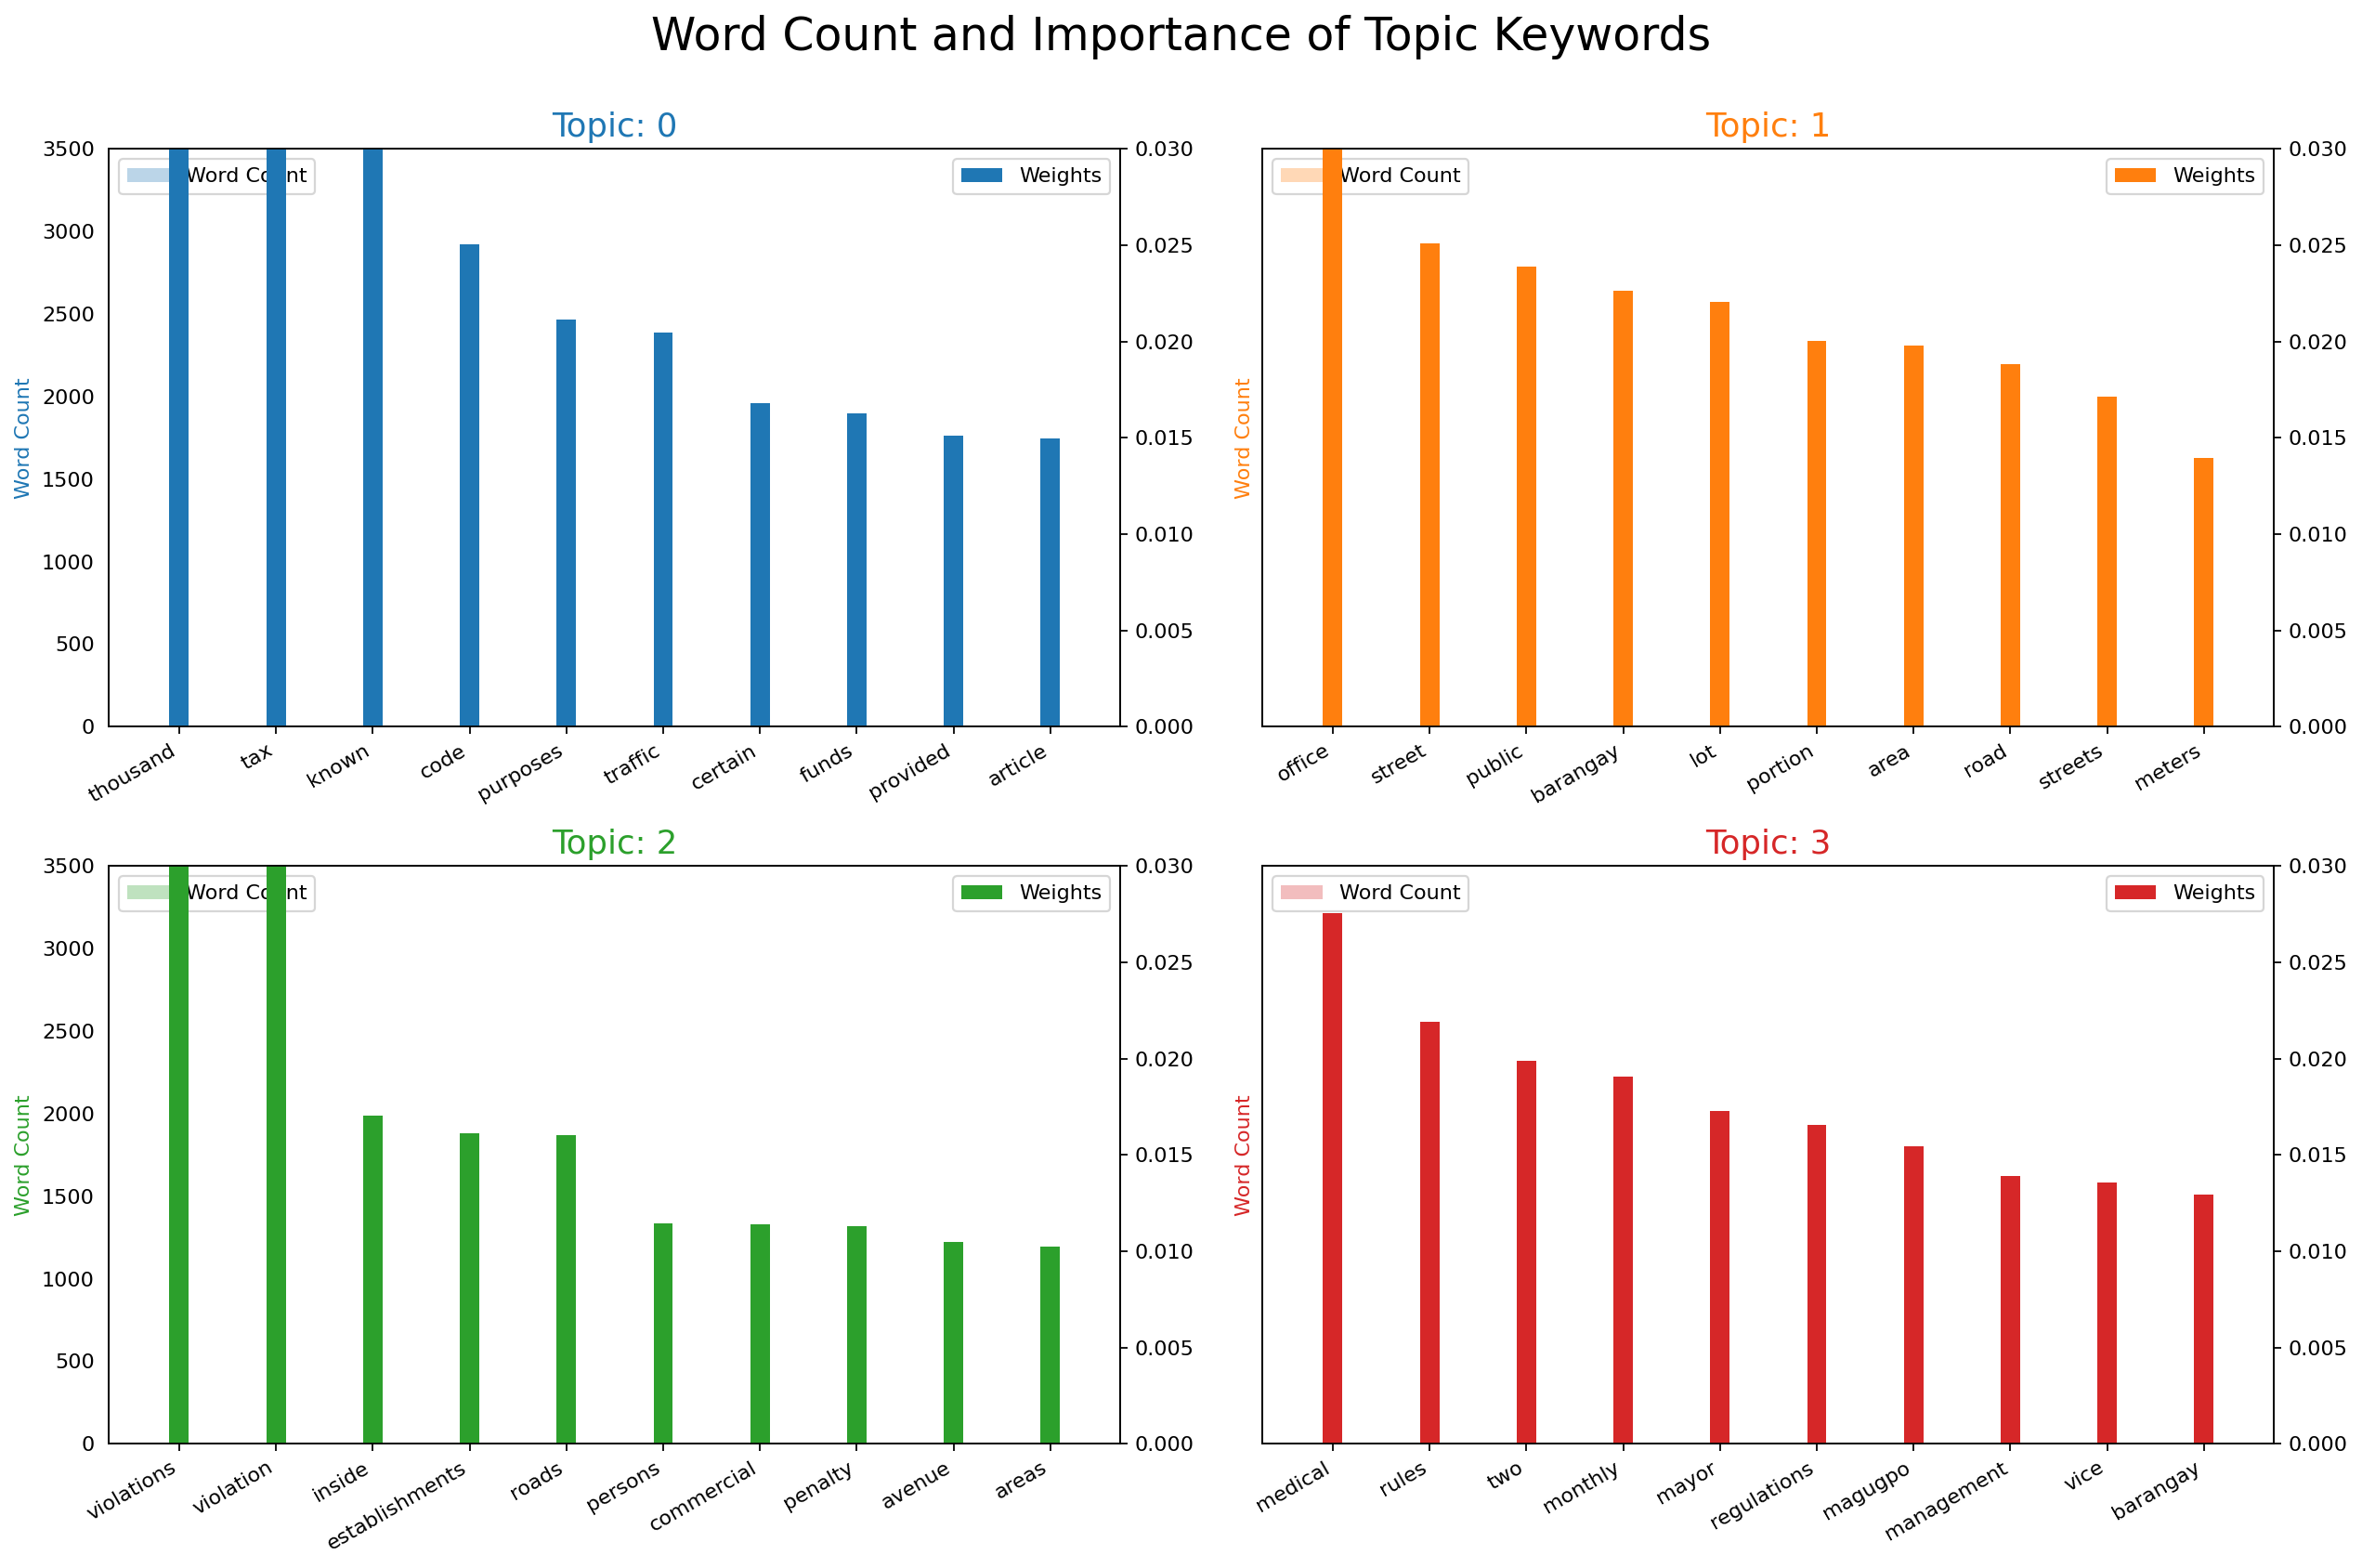

In [39]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [40]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)
from matplotlib.ticker import FuncFormatter


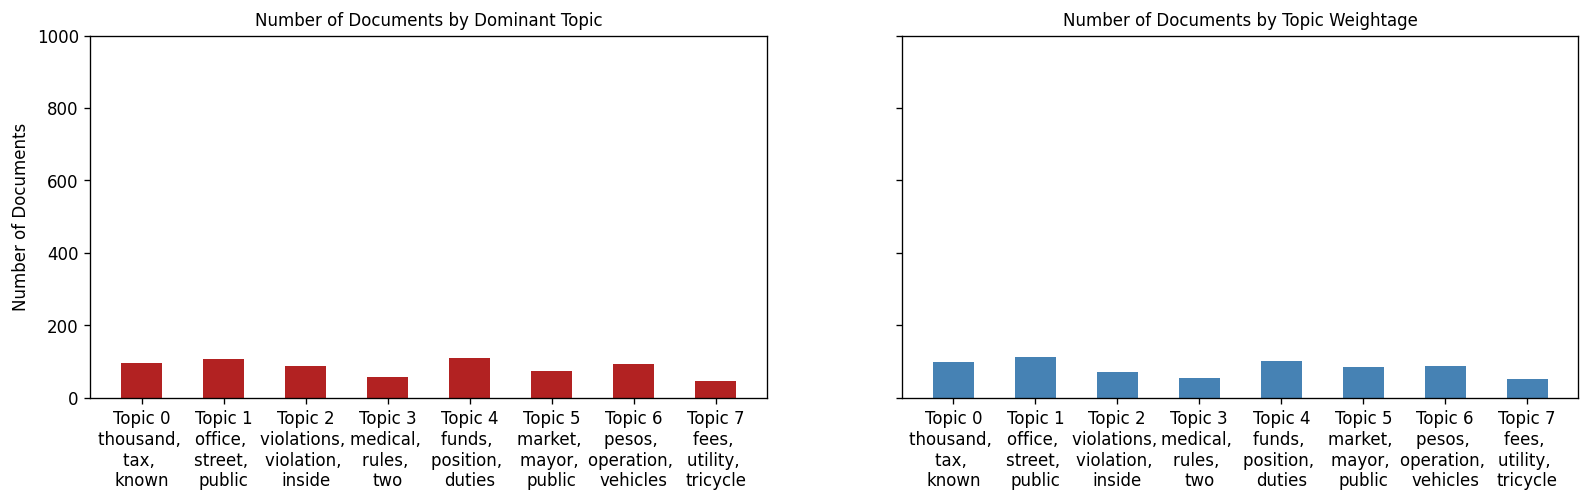

In [41]:

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [42]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.296745  0.036264       1        1  19.878591
6     -0.045694 -0.189023       2        1  14.361805
5      0.126509 -0.013443       3        1  13.981977
4     -0.103326  0.174563       4        1  13.009163
0     -0.094663  0.128885       5        1  12.000086
2     -0.075386 -0.179374       6        1  10.785957
3     -0.042956  0.087408       7        1   8.669475
7     -0.061229 -0.045280       8        1   7.312947, topic_info=            Term       Freq      Total Category  logprob  loglift
215       office  68.000000  68.000000  Default  30.0000  30.0000
238   violations  39.000000  39.000000  Default  29.0000  29.0000
34         funds  67.000000  67.000000  Default  28.0000  28.0000
560       market  45.000000  45.000000  Default  27.0000  27.0000
464     thousand  34.000000  34.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
24   regulations  12.686442  26.353836   Topic8  -3.7785   1.8844
31     violation  13.657131  53.830233   Topic8  -3.7048   1.2440
16    guidelines   8.239178  35.625038   Topic8  -4.2102   1.1514
15     functions   4.338323  18.841287   Topic8  -4.8516   1.1470
77        school   4.019639  30.113053   Topic8  -4.9279   0.6018

[331 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
168       5  0.978929             act
541       4  0.841314      additional
184       7  0.866237      administer
9         8  0.964371  administrative
1372      4  0.929198   administrator
...     ...       ...             ...
154       8  0.976897         workers
119       2  0.299898            year
119       3  0.599797            year
733       4  0.909369           years
167       1  0.986638            zone

[342 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 5, 1, 3, 4, 8])

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us